## GNN-based FEA Surrogate Model
Experimenting with basic GNN architectures from the repaired dataset leveraging
[PyTorch Geometric](https://github.com/pyg-team/pytorch_geometric)

Currently: GCN

In [1]:
import os
import glob
import torch
from torch_geometric.data import Data
import trimesh
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import sklearn

Total number of graphs in the dataset: 5001



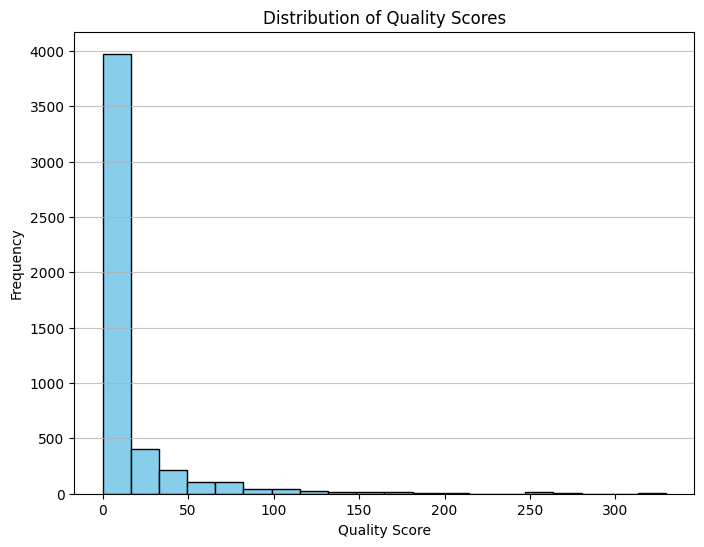

In [2]:
# Load Dataset from .pt file
dataset = torch.load('../data/processed/repaired_graph_dataset.pt')
print(f"Total number of graphs in the dataset: {len(dataset)}\n")

# View quality score dist
# TODO: Remove scores > 10
quality_scores = [g.y.item() for g in dataset]
plt.figure(figsize=(8, 6))
plt.hist(quality_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.title('Distribution of Quality Scores')
plt.grid(axis='y', alpha=0.75)
plt.show()

{"repaired_files/928f4ec8-e7f9-43f6-8939-bfa1f1ae1c20.stl010.stl": "25.999578663684655"}

#### View Graph Object Properties

In [3]:
graph_index = 4

In [4]:
graph = dataset[graph_index]

print(f"Properties of graph {graph_index}:")
print(graph)
print()
print(f"Node feature matrix (x): {graph.x.shape}")
print(f"Edge index (edge_index): {graph.edge_index.shape}")
print(f"Quality score (y): {graph.y.item()}")

Properties of graph 4:
Data(x=[8, 3], edge_index=[2, 36], y=[1])

Node feature matrix (x): torch.Size([8, 3])
Edge index (edge_index): torch.Size([2, 36])
Quality score (y): 6.86669397354126


Removed 1427 graphs with quality scores > 10.


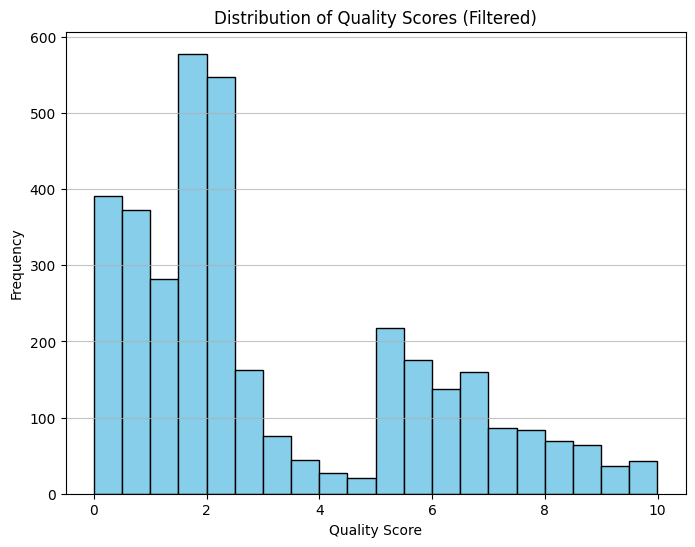

In [5]:
# Filter if QS > 10
initial_num_graphs = len(dataset)
filtered_dataset = [graph for graph in dataset if graph.y.item() <= 10]
filtered_num_graphs = len(filtered_dataset)
num_removed = initial_num_graphs - filtered_num_graphs
print(f"Removed {num_removed} graphs with quality scores > 10.")
dataset = filtered_dataset

# Plot QS dist
quality_scores = [graph.y.item() for graph in dataset]
plt.figure(figsize=(8, 6))
plt.hist(quality_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.title('Distribution of Quality Scores (Filtered)')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [6]:
# Save the filtered dataset
torch.save(dataset, '../data/processed/repaired_graph_dataset_filtered.pt')

### Preprocess
Use [sk.learn](https://scikit-learn.org/stable/) for splitting and preprocessing graphs.

In [ ]:
# TODO: Verify if scaling is feasible or if transformations are necessary
# Normalize node features (e.g., to zero mean and unit variance)
from sklearn.preprocessing import StandardScaler

for graph in dataset:
    scaler = StandardScaler()
    graph.x = torch.tensor(scaler.fit_transform(graph.x.numpy()), dtype=torch.float)

In [ ]:
# Split with reproducible seeding
from sklearn.model_selection import train_test_split

# Training and temp: 70/30
train_dataset, temp_dataset = train_test_split(dataset, test_size=0.3, random_state=42)

# 
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 2501
Validation set size: 536
Test set size: 537


In [8]:
batch_size = 32  # Adjust as needed based on your data size and memory constraints

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/Users/mihir/miniconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Training
Currently using the model: [Graph Convolutional Operator](https://pytorch-geometric.readthedocs.io/en/2.5.2/generated/torch_geometric.nn.conv.GCNConv.html)

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

In [10]:
class QualityPredictor(torch.nn.Module):
    def __init__(self):
        super(QualityPredictor, self).__init__()
        # Define layers
        self.conv1 = GCNConv(in_channels=3, out_channels=64)
        self.conv2 = GCNConv(in_channels=64, out_channels=32)
        self.fc = torch.nn.Linear(in_features=32, out_features=1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # Global mean pooling to get graph-level embeddings
        x = global_mean_pool(x, batch)
        
        # Final fully connected layer
        x = self.fc(x)
        
        # Output is a single value per graph
        return x.view(-1)

Modify parameters, optimizer, etc.

In [11]:
# TODO: Determine appropriate loss function
criterion = torch.nn.MSELoss()

In [20]:
num_epochs = 100  # Adjust based on your needs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QualityPredictor().to(device)

In [ ]:
# TODO: Optimize learning rate
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define RMSE calculation function
def rmse_loss(output, target):
    return torch.sqrt(torch.nn.functional.mse_loss(output, target))

# Scheduler variables
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 10  # Epochs to wait before stopping

# Store loss values
training_losses = []
validation_losses = []

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

/Users/mihir/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


#### Training Loop
Iterate through set # of epochs (complete pass through entire training dataset) to train model weights.

In [ ]:
# TODO: Convert to L1 Loss
for epoch in range(1, num_epochs + 1):
    #### Training Phase ####
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs  # Multiply by batch size

    avg_train_loss = total_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    #### Validation Phase ####
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y.to(device))
            total_val_loss += loss.item() * data.num_graphs

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    # Calculate RMSE for better interpretation
    train_rmse = avg_train_loss ** 0.5
    val_rmse = avg_val_loss ** 0.5

    print(f"Epoch {epoch}/{num_epochs}, Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

    # Scheduler
    scheduler.step(avg_val_loss)

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the best model weights
        torch.save(model.state_dict(), '../models/best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            # Load the best model weights before exiting
            model.load_state_dict(torch.load('../models/best_model.pth'))
            break

Epoch 1/100, Training RMSE: 4.0767, Validation RMSE: 3.8343
Epoch 2/100, Training RMSE: 3.6304, Validation RMSE: 3.4566
Epoch 3/100, Training RMSE: 3.3350, Validation RMSE: 3.2068
Epoch 4/100, Training RMSE: 2.9554, Validation RMSE: 2.8485
Epoch 5/100, Training RMSE: 2.7688, Validation RMSE: 2.7472
Epoch 6/100, Training RMSE: 2.6036, Validation RMSE: 2.6892
Epoch 7/100, Training RMSE: 2.5643, Validation RMSE: 2.6642
Epoch 8/100, Training RMSE: 2.5556, Validation RMSE: 2.6492
Epoch 9/100, Training RMSE: 2.5557, Validation RMSE: 2.6427
Epoch 10/100, Training RMSE: 2.5328, Validation RMSE: 2.6290
Epoch 11/100, Training RMSE: 2.6386, Validation RMSE: 2.6516
Epoch 12/100, Training RMSE: 2.5351, Validation RMSE: 2.6348
Epoch 13/100, Training RMSE: 2.5179, Validation RMSE: 2.6159
Epoch 14/100, Training RMSE: 2.5090, Validation RMSE: 2.6096
Epoch 15/100, Training RMSE: 2.5031, Validation RMSE: 2.6022
Epoch 16/100, Training RMSE: 2.5025, Validation RMSE: 2.6036
Epoch 17/100, Training RMSE: 2.61

#### Evaluation

Training RMSE=$\sqrt{TrainingLoss}$

Validation RMSE=$\sqrt{ValidationLoss}$

In [ ]:
# TODO: Logging to Wandb
# Compute Loss
model.eval()
total_test_loss = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data.y.to(device))
        total_test_loss += loss.item() * data.num_graphs

avg_test_loss = total_test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 5.8447


In [26]:
# Compute MAE
from sklearn.metrics import mean_absolute_error

model.eval()
true_values = []
predicted_values = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        true_values.extend(data.y.cpu().numpy())
        predicted_values.extend(output.cpu().numpy())

mae = mean_absolute_error(true_values, predicted_values)
print(f"Test MAE: {mae:.4f}")

Test MAE: 1.8566


Save Model

In [27]:
# Save State Dictionary
torch.save(model.state_dict(), '../models/quality_predictor_model.pth')

# Save Entire Model
torch.save(model, '../models/quality_predictor_entire_model.pth')